# Descriptive Statistics

Notebook with the descriptive statistics of the graph

In [3]:
import os

# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp
from datetime import datetime

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from utils.Functions import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import pickle
from glob import glob
from tqdm import tqdm
import random

/mnt/disk2/anaconda3/envs/gt_global/lib/python3.11/site-packages/graph_tool/draw/cairo_draw.py:1544: RuntimeWarning: Error importing Gtk module: ; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


## Retweet network with a 3-day rolling window

In [13]:
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

ls = []
for file in tqdm(files):
    # Get date
    date = file.split('/')[-1].split('.')[0]
    date = datetime.strptime(date, '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Get Node Degrees Average
    for stat in ['in', 'out', 'total']: 
        vertex_average = gt.vertex_average(g, stat)
        row = [vertex_average[0], vertex_average[1], date, f'Average Degree {stat}']
        ls.append(row)
        
    # Get Edge Propety Average
    for stat in dict(g.ep).items():
        try:
            edge_average = gt.edge_average(g, stat[1])
            row = [edge_average[0], edge_average[1], date, stat[0]]
            ls.append(row)
        except:
            pass
    
    # Get Assortativity
    assortativity = gt.assortativity(g, g.vp['Political Label'])
    row = [assortativity[0], assortativity[1], date, 'Assortativity']
    ls.append(row)
    
    # Clustering and transitivity
    cluester_coef = gt.global_clustering(g,weight = g.ep['Normal Weights'])
    row = [cluester_coef[0], cluester_coef[1], date, 'Global Clustering Coefficient']
    ls.append(row)
    
    transitivity = gt.global_clustering(g)
    row = [transitivity[0], transitivity[1], date, 'Transitivity']
    ls.append(row)

# Get Visualization
viz = pd.DataFrame(ls, columns=['Value','SE','Date', 'Statistic'])

# Get Confidence Interval
viz['Lower'] = viz['Value'] - 1.96*viz['SE']
viz['Upper'] = viz['Value'] + 1.96*viz['SE']
viz = viz.set_index('Date')
viz = viz.sort_index()
viz

,Value,SE,Statistic,Lower,Upper
Date,,,,,
2021-05-01,12.645638,0.638589,Average Degree in,11.394004,13.897271
2021-05-01,25.291276,0.658127,Average Degree total,24.001347,26.581205
2021-05-01,0.060879,0.000182,Normal Weights,0.060521,0.061237
2021-05-01,1.750345,0.003990,Number of rts,1.742524,1.758165
2021-05-01,138.778058,0.272763,Total of rts,138.243443,139.312674
...,...,...,...,...,...
2021-06-30,74.098047,0.207829,Total of rts,73.690701,74.505393
2021-06-30,0.018462,0.002089,Transitivity,0.014367,0.022558
2021-06-30,1.583511,0.005005,Number of rts,1.573701,1.593322


In [14]:
viz.loc['2021-06-30']

,Value,SE,Statistic,Lower,Upper
Date,,,,,
2021-06-30,5.978303,0.074210,Average Degree out,5.832852,6.123754
2021-06-30,5.978303,0.307329,Average Degree in,5.375938,6.580667
2021-06-30,0.111748,0.000414,Normal Weights,0.110937,0.112559
2021-06-30,0.002525,0.000704,Global Clustering Coefficient,0.001145,0.003905
2021-06-30,74.098047,0.207829,Total of rts,73.690701,74.505393
2021-06-30,0.018462,0.002089,Transitivity,0.014367,0.022558
2021-06-30,1.583511,0.005005,Number of rts,1.573701,1.593322
2021-06-30,0.560587,0.001311,Assortativity,0.558017,0.563157
2021-06-30,11.956605,0.319873,Average Degree total,11.329655,12.583556


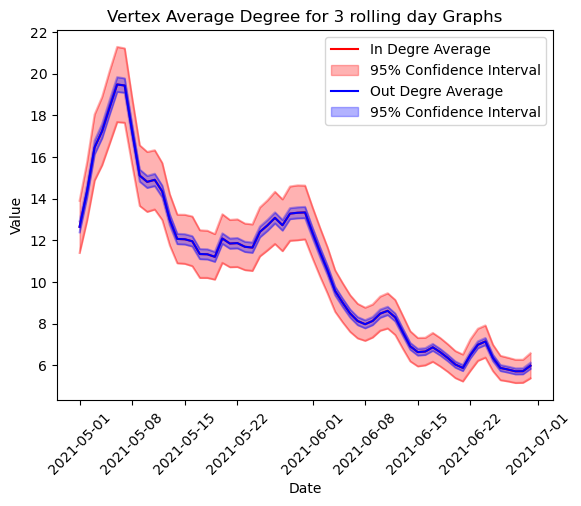

In [9]:
# Separate Types
in_deg = viz[viz['Statistic'] == 'Average Degree in']
out_deg = viz[viz['Statistic'] == 'Average Degree out']

# GRAAAAAPH
fig, ax = plt.subplots()

# In Graph
sns.lineplot(data=in_deg, x=in_deg.index, y='Value', color='red', ax=ax, label='In Degre Average')
sns.lineplot(data=in_deg, x=in_deg.index, y='Lower', color='red', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=in_deg, x=in_deg.index, y='Upper', color='red', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(in_deg.index, in_deg['Lower'], in_deg['Upper'], color='red', alpha=0.3, label='95% Confidence Interval')

# Out Graph
sns.lineplot(data=out_deg, x=out_deg.index, y='Value', color='blue', ax=ax, label='Out Degre Average')
sns.lineplot(data=out_deg, x=out_deg.index, y='Lower', color='blue', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=out_deg, x=out_deg.index, y='Upper', color='blue', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(out_deg.index, out_deg['Lower'], out_deg['Upper'], color='blue', alpha=0.3, label='95% Confidence Interval')

# Labels
plt.title('Vertex Average Degree for 3 rolling day Graphs')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Edge Properties Statistics for 3 rolling day Graphs')

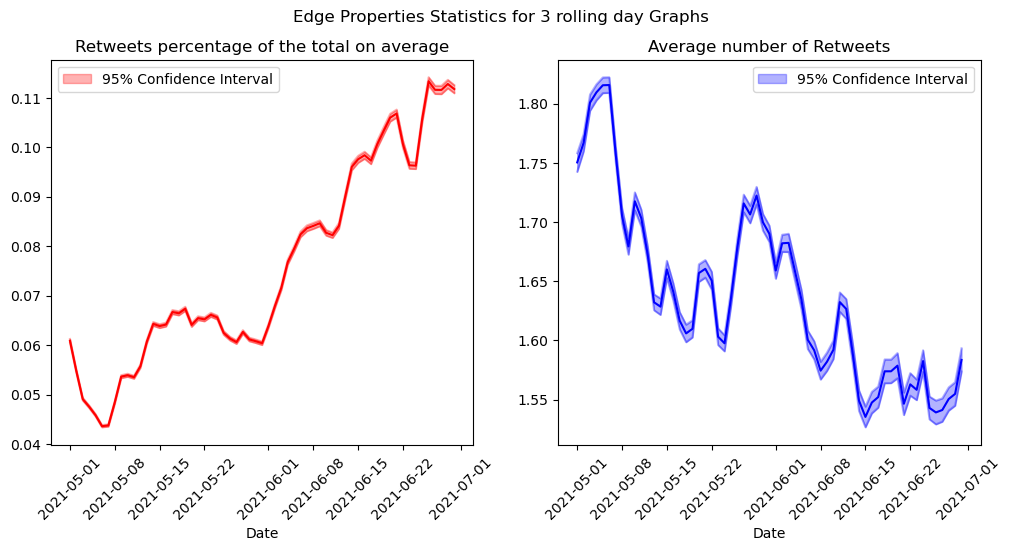

In [12]:
# Separate Types
normal = viz[viz['Type'] == 'Normal Weights']
number = viz[viz['Type'] == 'Number of rts']

# GRAAAAAPH
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=normal, x=normal.index, y='Value', color='red', ax=ax[0], label='_nolegend')
sns.lineplot(data=normal, x=normal.index, y='Lower', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')
sns.lineplot(data=normal, x=normal.index, y='Upper', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')

ax[0].fill_between(normal.index, normal['Lower'], normal['Upper'], color='red', alpha=0.3, label='95% Confidence Interval')

ax[0].set_title('Retweets percentage of the total on average')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('')
ax[0].legend()

# Out Graph
sns.lineplot(data=number, x=number.index, y='Value', color='blue', ax=ax[1], label='_nolegend_')
sns.lineplot(data=number, x=number.index, y='Lower', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')
sns.lineplot(data=number, x=number.index, y='Upper', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')

ax[1].fill_between(number.index, number['Lower'], number['Upper'], color='blue', alpha=0.3, label='95% Confidence Interval')

ax[1].set_title('Average number of Retweets')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('')
ax[1].legend()
fig.suptitle('Edge Properties Statistics for 3 rolling day Graphs')

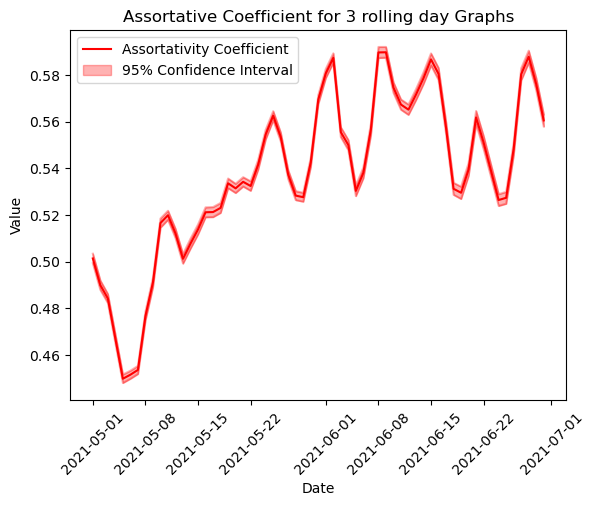

In [40]:
# Separate Types
assort = viz[viz['Statistic'] == 'Assortativity']

# GRAAAAAPH
fig, ax = plt.subplots()

# In Graph
sns.lineplot(data=assort, x=assort.index, y='Value', color='red', ax=ax, label='Assortativity Coefficient')
sns.lineplot(data=assort, x=assort.index, y='Lower', color='red', ax=ax, alpha=0.3, label='_nolegend_')
sns.lineplot(data=assort, x=assort.index, y='Upper', color='red', ax=ax, alpha=0.3, label='_nolegend_')

plt.fill_between(assort.index, assort['Lower'], assort['Upper'], color='red', alpha=0.3, label='95% Confidence Interval')

# Labels
plt.title('Assortative Coefficient for 3 rolling day Graphs')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Text(0.5, 0.98, 'Clustering for 3 rolling day Graphs')

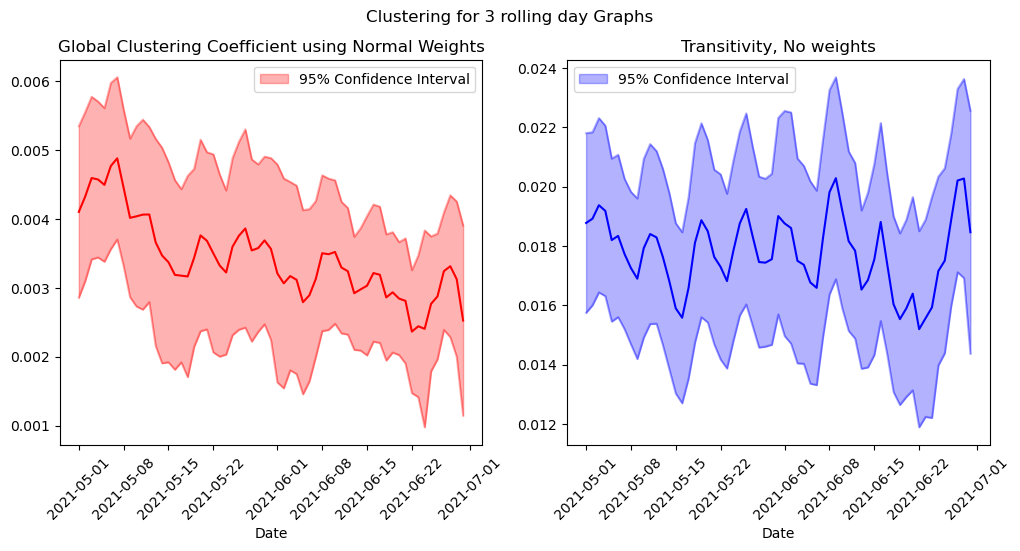

In [42]:
# Separate Types
clust = viz[viz['Statistic'] == 'Global Clustering Coefficient']
transit = viz[viz['Statistic'] == 'Transitivity']

# GRAAAAAPH
fig, ax = plt.subplots(1,2,figsize=(12, 5))

# In Graph
sns.lineplot(data=clust, x=clust.index, y='Value', color='red', ax=ax[0], label='_nolegend')
sns.lineplot(data=clust, x=clust.index, y='Lower', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')
sns.lineplot(data=clust, x=clust.index, y='Upper', color='red', ax=ax[0], alpha=0.3, label='_nolegend_')

ax[0].fill_between(clust.index, clust['Lower'], clust['Upper'], color='red', alpha=0.3, label='95% Confidence Interval')

ax[0].set_title('Global Clustering Coefficient using Normal Weights')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('')
ax[0].legend()

# Out Graph
sns.lineplot(data=transit, x=transit.index, y='Value', color='blue', ax=ax[1], label='_nolegend_')
sns.lineplot(data=transit, x=transit.index, y='Lower', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')
sns.lineplot(data=transit, x=transit.index, y='Upper', color='blue', ax=ax[1], alpha=0.3, label='_nolegend_')

ax[1].fill_between(transit.index, transit['Lower'], transit['Upper'], color='blue', alpha=0.3, label='95% Confidence Interval')

ax[1].set_title('Transitivity, No weights')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_ylabel('')
ax[1].legend()
fig.suptitle('Clustering for 3 rolling day Graphs')

In [62]:
# Runtime 36 minutes
basic_measures = []
for file in tqdm(files):
    g = gt.load_graph(file)
    basic_measures.append(descriptive(g))

basic_measures = pd.concat(basic_measures)
basic_measures = basic_measures.sort_index()
basic_measures

100%|██████████| 61/61 [36:41<00:00, 36.10s/it] 


,Nodes,Edges,Dyads,Density,Strongly Connected Components,Weakly Connected Components,Diametro Simple
Graph Date,,,,,,,
2021-05-01,36886,466447,233223.5,0.000343,28841,6934,18.0
2021-05-02,36912,529751,264875.5,0.000389,28280,6387,19.0
2021-05-03,36925,607679,303839.5,0.000446,27394,5598,19.0
2021-05-04,36945,637129,318564.5,0.000467,27031,5207,21.0
2021-05-05,36964,679455,339727.5,0.000497,26522,4388,18.0
...,...,...,...,...,...,...,...
2021-06-26,36961,217001,108500.5,0.000159,32338,10598,22.0
2021-06-27,36964,214247,107123.5,0.000157,32534,11196,22.0
2021-06-28,36964,211042,105521.0,0.000154,32434,11603,20.0


In [56]:
basic_measures.describe().round(2)

,Nodes,Edges,Dyads,Density,Strongly Connected Components,Weakly Connected Components,Diametro Simple
count,61.00,61.00,61.00,61.0,61.00,61.00,61.00
mean,36960.75,396204.69,198102.34,0.0,30458.90,8114.36,19.77
std,12.94,139338.34,69669.17,0.0,1762.84,2319.93,1.68
min,36886.00,211042.00,105521.00,0.0,26168.00,4172.00,17.00
25%,36964.00,258174.00,129087.00,0.0,29462.00,6269.00,19.00
50%,36964.00,419185.00,209592.50,0.0,30419.00,7463.00,19.00
75%,36964.00,480015.00,240007.50,0.0,32132.00,10490.00,21.00
max,36964.00,720093.00,360046.50,0.0,32623.00,12147.00,25.00


/home/fcastrillon/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


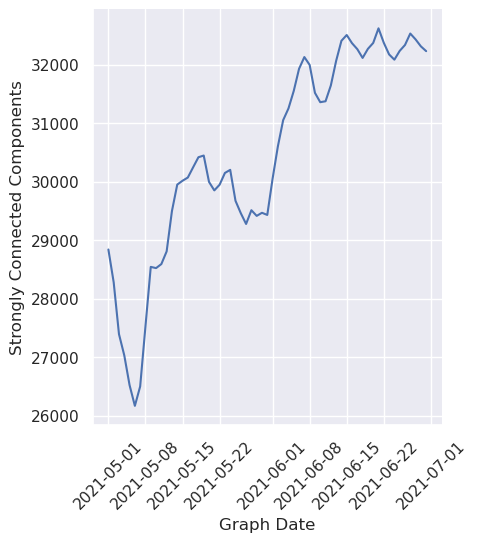

In [79]:
sns.relplot(
    kind='line',
    data = basic_measures,
    y = 'Strongly Connected Components',
    x= basic_measures.index
)
plt.xticks(rotation = 45)
plt.show()

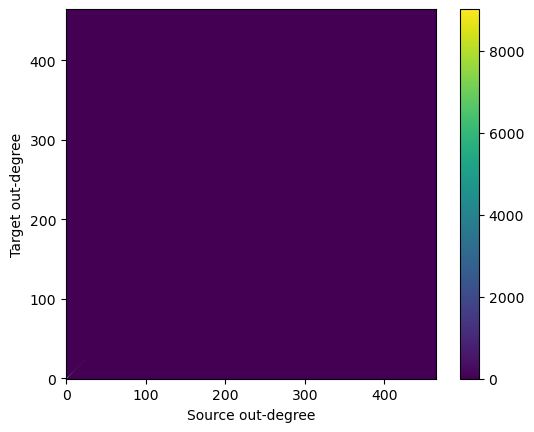

In [43]:
h = gt.combined_corr_hist(g, "out", "out", float_count=True)
plt.xlabel("Source out-degree")
plt.ylabel("Target out-degree")
plt.imshow(h[0].T, interpolation="nearest", origin="lower")
plt.colorbar()

In [57]:
basic_measures.sort_index(inplace=True)

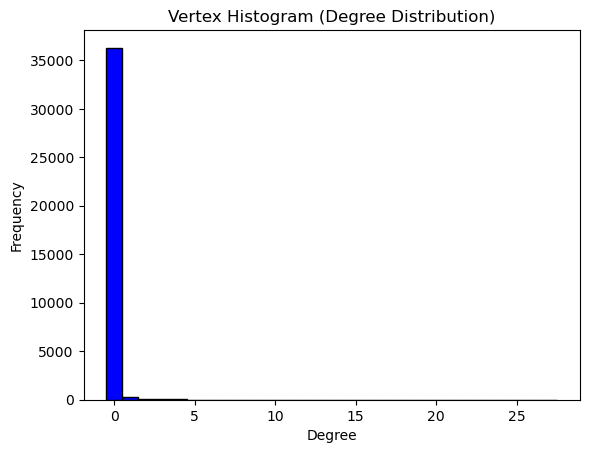

In [44]:
g = gt.load_graph('/mnt/disk2/Data/3_Day_Graphs/2021-05-01.graphml')
deg = gt.vertex_hist(g,'total',bins=[0,200])
plt.figure()
plt.bar(range(len(deg[0])), deg[0], width=1.0, color='b', edgecolor='black')
plt.title('Vertex Histogram (Degree Distribution)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## Daily retweet network (with no rolling window)

In [4]:
files = glob('/mnt/disk2/Data/Daily_graphs/*.graphml')

### Segregation statistics

In [83]:
ls = []
for file in tqdm(files):
    # Get date
    date = datetime.strptime(file.split('/')[-1].split('.')[0], '%Y-%m-%d')
    g = gt.load_graph(file)
    
    # Check for edge weight property
    if "weight" in g.edge_properties:
        weight_prop = g.ep["weight"]
    else:
        weight_prop = None

    # Get Node Degrees Average
    for stat in ['in', 'out', 'total']: 
        vertex_average = gt.vertex_average(g, stat)
        ls.append([vertex_average[0], vertex_average[1], date, f'Average Degree {stat}'])
        
    # Get Edge Property Average
    for stat, prop in g.edge_properties.items():
        try:
            edge_average = gt.edge_average(g, prop)
            ls.append([edge_average[0], edge_average[1], date, stat])
        except Exception as e:
            print(f"Error processing edge property {stat}: {e}")
    
    # Get Assortativity
    assortativity = gt.assortativity(g, g.vp['Label'])
    ls.append([assortativity[0], assortativity[1], date, 'Assortativity'])
    
    # Clustering and transitivity
    cluester_coef = gt.global_clustering(g, weight=weight_prop)
    ls.append([cluester_coef[0], cluester_coef[1], date, 'Global Clustering Coefficient'])
    
    transitivity = gt.global_clustering(g)
    ls.append([transitivity[0], transitivity[1], date, 'Transitivity'])

    # Centrality measures
    vertex_betweenness, edge_betweenness = gt.betweenness(g, weight=weight_prop)
    ls.append([float(np.mean(edge_betweenness.a)), float(np.std(edge_betweenness.a)), date, 'Edge Betweenness'])

    pagerank_scores = gt.pagerank(g, weight=weight_prop)
    ls.append([float(np.mean(pagerank_scores.a)), float(np.std(pagerank_scores.a)), date, 'PageRank'])

    eigenvector_values, eigenvector = gt.eigenvector(g, weight=weight_prop)
    ls.append([float(np.mean(eigenvector.a)), float(np.std(eigenvector.a)), date, 'Eigenvector Centrality'])

# Create DataFrame
viz = pd.DataFrame(ls, columns = ['Value', 'Standard Deviation', 'Date', 'Statistic'])

# Convert to numeric where applicable
viz['Value'] = pd.to_numeric(viz['Value'], errors='coerce')
viz['Standard Deviation'] = pd.to_numeric(viz['Standard Deviation'], errors='coerce')

viz.head()

100%|██████████| 63/63 [02:18<00:00,  2.19s/it]


,Value,Standard Deviation,Date,Statistic
0,5.371739,0.340534,2021-06-12,Average Degree in
1,5.371739,0.071747,2021-06-12,Average Degree out
2,10.743477,0.347590,2021-06-12,Average Degree total
3,1.291917,0.003931,2021-06-12,weight
4,0.590234,0.002018,2021-06-12,Assortativity


In [86]:
viz['Lower'] = viz['Value'] - 1.96*viz['Standard Deviation']
viz['Upper'] = viz['Value'] + 1.96*viz['Standard Deviation']

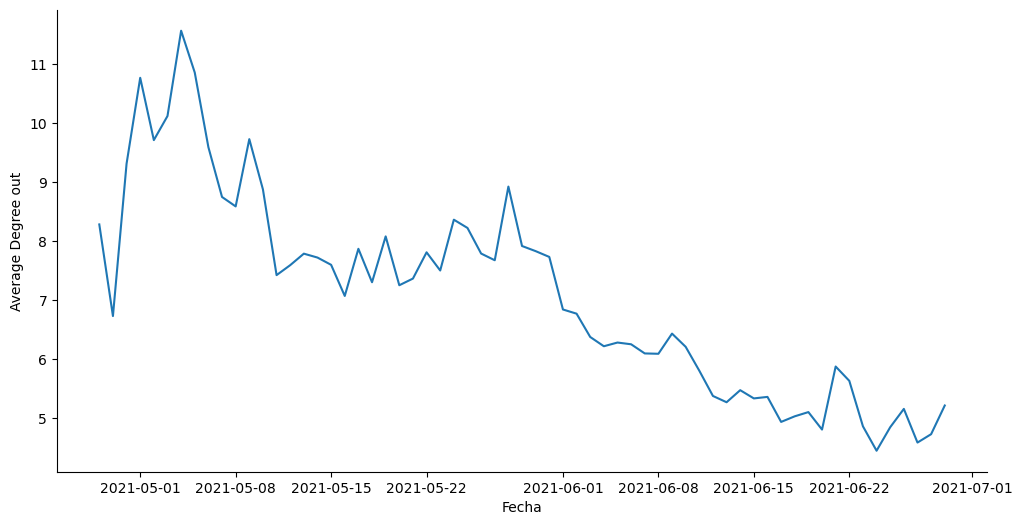

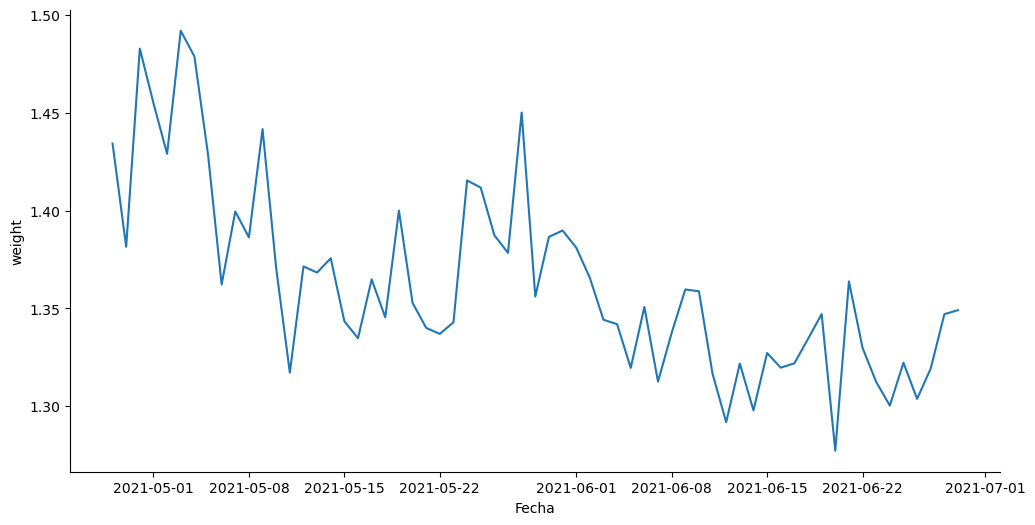

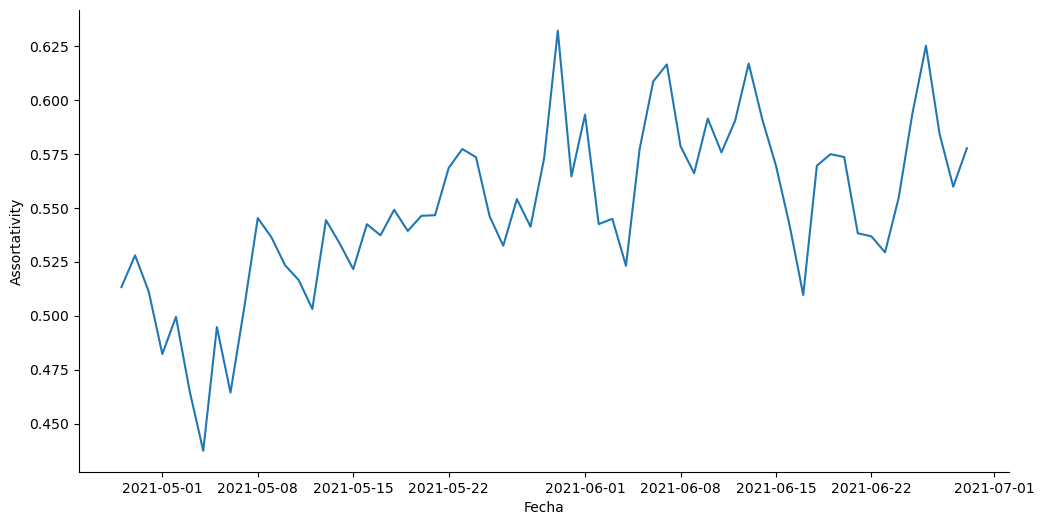

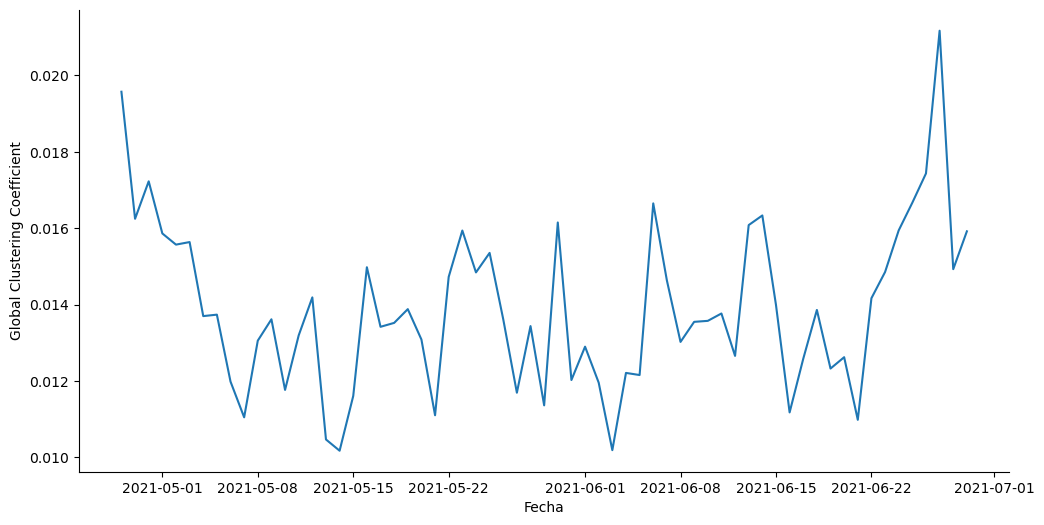

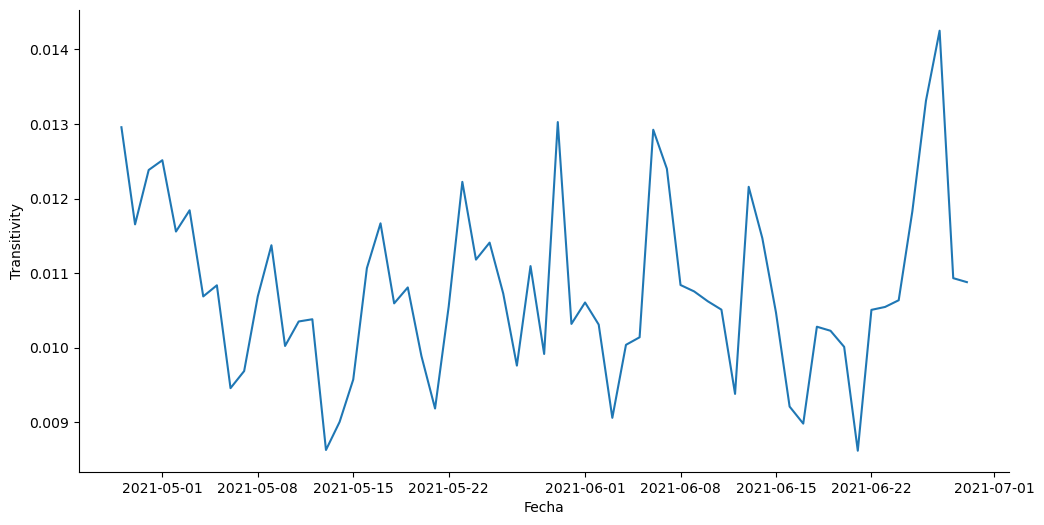

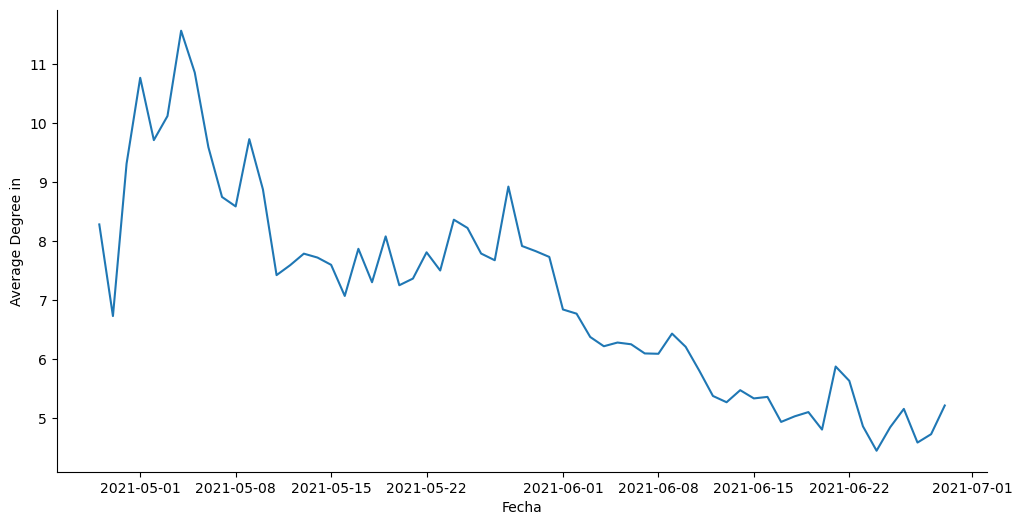

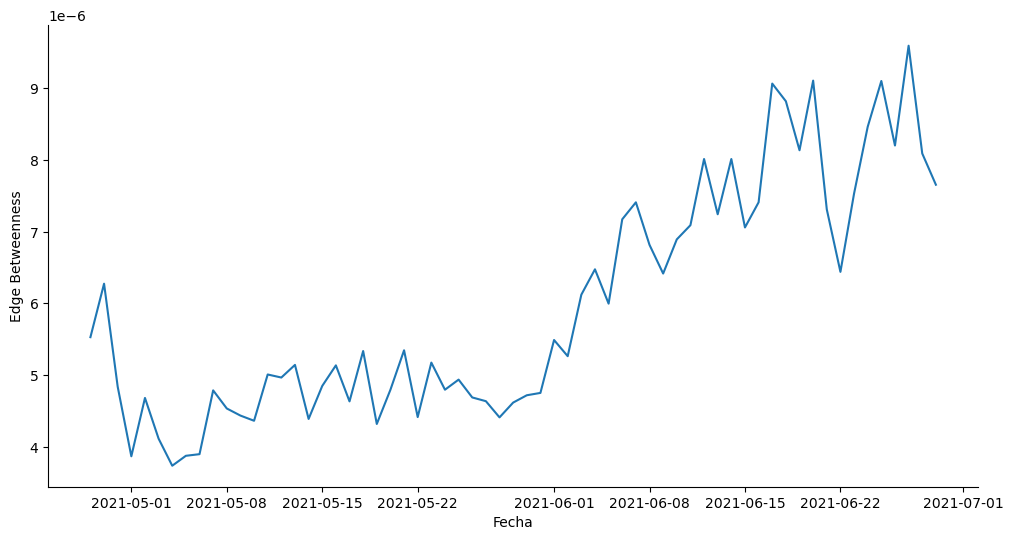

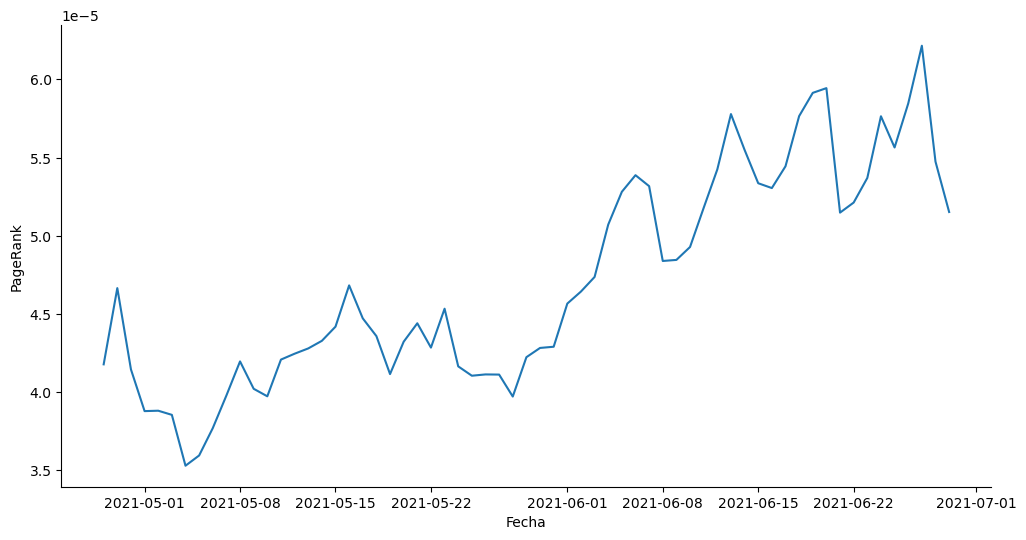

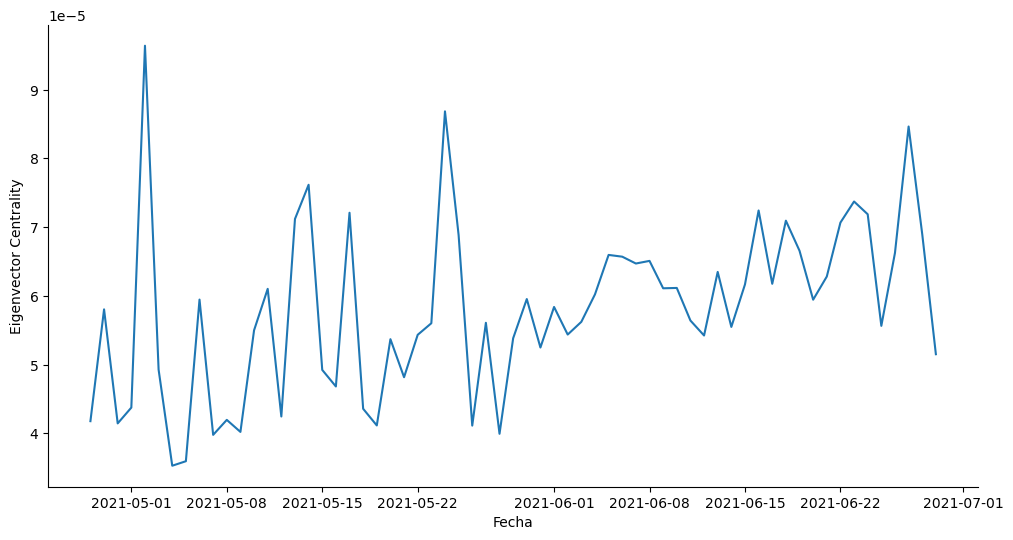

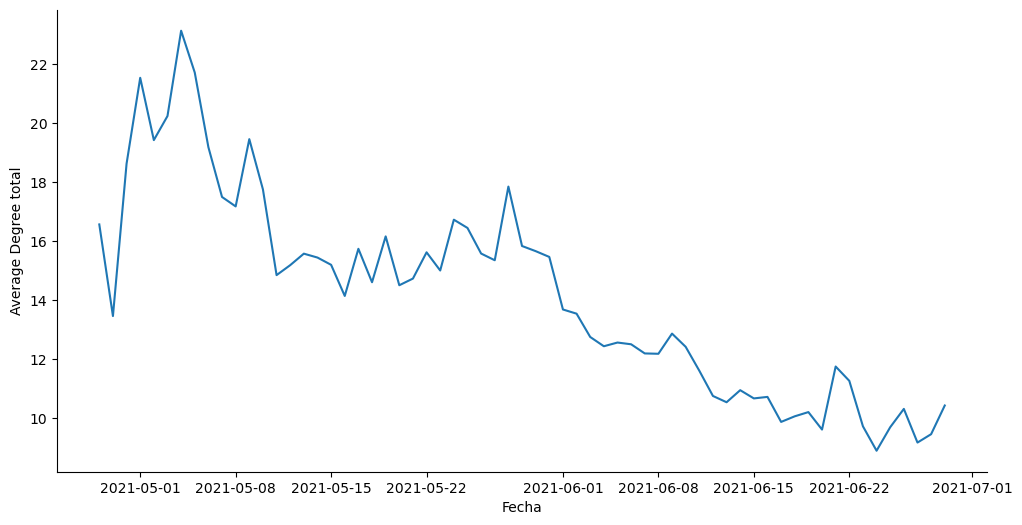

In [113]:
for i in viz["Statistic"].unique():
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.despine()
    sns.lineplot(data = viz.query(f"Statistic == '{i}'"), x = "Date", y = "Value", ax = ax)
    # ax.fill_between(x = viz.query("Statistic == '{i}'")["Date"], y1 = viz.query("Statistic == '{i}'")["Lower"], 
    #                 y2 = viz.query("Statistic == '{i}'")["Upper"], alpha = 0.3)
    plt.xlabel("Fecha")
    plt.ylabel(i)